## Importing relevant libraries

In [1]:
import numpy as np
import scipy.linalg as la
import scipy.spatial as spat
from scipy.stats import unitary_group
from scipy.stats import moment
from scipy.stats import skew, kurtosis
from scipy.optimize import curve_fit
from scipy.linalg import norm
import matplotlib.pyplot as plt
import math
from dataclasses import dataclass

# Libraries for implementing the VQD algorithm
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.primitives import Sampler
from qiskit.primitives import Estimator as EstimatorOld
from qiskit_aer import AerSimulator
from qiskit_algorithms.utils import algorithm_globals
# from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Sampler, Session, Options
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import RealAmplitudes, TwoLocal, EfficientSU2
from qiskit_algorithms.optimizers import *
from qiskit_algorithms.state_fidelities import ComputeUncompute

from qiskit_algorithms.eigensolvers import EigensolverResult, VQD
from qiskit_algorithms import NumPyMinimumEigensolver, VQE
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session, Options

# Import classical optimizers
from qiskit_algorithms.optimizers import SPSA, P_BFGS, COBYLA, IMFIL, SNOBFIT, NELDER_MEAD, SLSQP, NFT, ADAM, POWELL, GradientDescent, BOBYQA

# Import Statevector and SparsePauliOp
from qiskit.quantum_info import SparsePauliOp, Statevector

# Import noise models
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

# Import a fake backend and Qiskit simulators and/or noise libraries
from qiskit_aer import AerSimulator
# from qiskit_aer.primitives import Estimator as AerEstimator 
# from qiskit_aer.noise import NoiseModel

## Import a fake backend instead (mimics the behavior of a real backend)
from qiskit_ibm_runtime.fake_provider import FakeManilaV2, FakeMontrealV2, FakeGuadalupeV2, FakeManila

# Get the backend
backend = FakeManilaV2()

## Construct the Schlogl operator

In [5]:
def TridiagA(lambda_func, mu_func, N):
    """
    Creates tridiagonal stochastic matrix for the Schlogl model
    Inputs lambda and mu model functions, and N desired size of matrix
    Returns stochastic matrix (non-hermitian)
    """
    # initialize diagonals
    d1 = np.zeros(N - 1)
    d2 = np.zeros(N)
    d3 = np.zeros(N - 1)

    # element 1,1
    d2[0] = -lambda_func(0)

    # element N,N
    d2[N - 1] = -mu_func(N - 1)

    # bottom diagonal elements
    for i in range(N - 1):
        d1[i] = lambda_func(i)

    # top diagonal elements
    for i in range(1, N):
        d3[i - 1] = mu_func(i)

    # main diagonal elements
    for i in range(1, N - 1):
        d2[i] = -lambda_func(i) - mu_func(i)

    # putting the diagonals together
    Q = np.diag(d1, k = -1) + np.diag(d2, k = 0) + np.diag(d3, k = 1)
    
    return Q

def get_volume_array(start_V, stop_V, n_operator_qubits):
    # Function to generate the initial volume array (to carry out computations)
    
    num_elements = 2 ** n_operator_qubits
    step_size = (stop_V - start_V)/(num_elements - 1)
    
    # Generate the volume array, given that the step size has been determined
    volume_array = np.arange(start_V, stop_V, step_size)
    
    return volume_array

def get_unitary(matrix, add_half = False):
    """
    Purpose: given a matrix, returns the unitary, hermitian matrix to be diagonalized
    Input: matrix -> the matrix to be diagonalized
    Output: U -> the unitary matrix
            nqubits -> the number of qubis needed to represent the basis of U
            dimension -> the dimension of the original matrix
    """
    assert matrix.ndim == 2, "Error: Only a matrix maybe processed"
    assert matrix.shape[0] == matrix.shape[1], "Error: Only a square matrix maybe processed"

    if np.any(np.transpose(matrix) != matrix):
        matrix_T = np.transpose(matrix)
        matrix = np.dot(matrix_T, matrix)

    ## Finding the dimension of the matrix
    dimension_hermitian = matrix.shape[0]

    ## Finding the number of qubits required to represent the matrix
    nqubits = int(np.ceil(np.log2(dimension_hermitian)))

    ## Construct the relevant matrix
    op_dim = 2 ** nqubits
    op = np.eye(op_dim)
    op[0:dimension_hermitian, 0:dimension_hermitian] = np.copy(matrix)

    if add_half:
        op = op + np.pi * np.eye(op.shape[0])

    U = la.expm(1j*op)
    
    # Get the dimensions of the unitary matrix
    dimension = U.shape[0]

    return U, nqubits, dimension

def find_probability(eigenvector_raw):
    """
    Purpose: Find the probability associated with each basis of an eigenvector
    Input: eigenvector_raw -> Numpy array documenting the number of times each basis is detected within the eigenvector
    Output: eigenvector_prob -> Numpy array documenting the probability of detecting each basis
    """
    count_total = np.sum(eigenvector_raw)
    eigenvector_prob = eigenvector_raw / count_total
    
    return eigenvector_prob

def find_amplitude(eigenvector_prob):
    """
    Purpose: Finding the probability amplitude of each basis using quantum mechanics
    Input: eigenvector_prob -> Numpy array documenting the probability that each basis is measured
    Output: eigenvector -> Numpy array representing the eigenvector
    """
    eigenvector = np.sqrt(eigenvector_prob)
    return eigenvector

def normalize_eigenvector(vector):
    """
    Purpose: Normalizes a vector such that its norm is 1
    Input: vector -> The vector to be normalized
    Output: vector -> The normalized vector
    """
    L2 = np.sum(np.square(vector))
    vector = vector / np.sqrt(L2)

    return vector

def get_similarity(a, b):
    # Function to compute the similarity between 2 zeromodes

    # Get absolute values
    b = np.abs(b)
    
    numerator = np.abs(np.dot(a.conj().T, b))**2
    denominator = np.linalg.norm(a)**2 * np.linalg.norm(b)**2
    
    return numerator / denominator

def get_expectation(matrix, zeromode):
    # Compute the expectation value of the Schlogl operator in the steady-state
    
    # Convert the zeromode into a matrix (column vector)    
    zeromode = np.array(zeromode).reshape(len(zeromode), 1)
    zeromode = np.abs(zeromode) # get rid of all (extraneous) negative values (since this is a PDF)
    
    # Compute the steady-state expectation value
    value = np.dot(matrix, zeromode)
    expectation_value = np.dot(zeromode.T, value)
    
    return expectation_value

def compute_rmsd(list1, list2):
    # Ensure the lists have the same length
    
    if len(list1) != len(list2):
        raise ValueError("Lists must have the same length.")
    
    # Compute the RMSD
    rmsd = np.sqrt(np.mean((np.array(list1) - np.array(list2)) ** 2))
    return rmsd

def get_expectation(matrix, zeromode):
    # Compute the expectation value of the Schlogl operator in the steady-state
    
    # Convert the zeromode into a matrix (column vector)    
    zeromode = np.array(zeromode).reshape(len(zeromode), 1)
    zeromode = np.abs(zeromode) # get rid of all (extraneous) negative values (since this is a PDF)
    
    # Compute the steady-state expectation value
    value = np.dot(matrix, zeromode)
    expectation_value = np.dot(zeromode.T, value)
    
    return expectation_value

def get_similarity(a, b):
    # Function to compute the similarity between 2 zeromodes

    # Transform into arrays
    a = np.array(a).reshape(len(a), 1)
    b = np.array(b).reshape(len(b), 1)
    
    numerator = np.abs(np.dot(a.conj().T, b))**2
    denominator = np.linalg.norm(a)**2 * np.linalg.norm(b)**2
    
    return numerator / denominator

## VQD implementation

In [8]:
# Define the VQD computation with varying ansatz depth
def run_vqd(matrix, ansatz, optimizer, seed, shots, backend):
    # Function to compute the execution time for different optimizers and ansatz depths (averaged over 10 independent VQD runs in each case)

    dimension = matrix.shape[0]
    num_qubits = int(np.log2(dimension))
    
    # Define the qubit Hamiltonian
    qub_hamiltonian = SparsePauliOp.from_operator(matrix)

    # Compute using NumPyMinimumEigensolver for reference
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qub_hamiltonian)
    
    # Initial point for the classical optimizer
    seed_value = seed
    np.random.seed(seed_value)
    initial_point = np.random.uniform(-np.pi, np.pi, ansatz.num_parameters)

    # Initialize the Estimator primitive with backend options
    noise_model = NoiseModel.from_backend(backend)
    
    # Get the device characteristics
    basis_gates = noise_model.basis_gates
    coupling_map = backend.coupling_map
    backend = AerSimulator(noise_model = noise_model, coupling_map = coupling_map, \
                           basis_gates = basis_gates)

    # Set up Options()
    options = Options()
    options.execution.shots = shots
    options.resilience_level = 2
    options.seed_simulator = 1
    options.optimization_level = 3
    
    # Initializing the Estimator, Sampler, and fidelity
    estimator = Estimator(backend = backend, options = options)
    sampler = Sampler()
    fidelity = ComputeUncompute(sampler)
    
    # Run the VQE algorithm
    @dataclass
    class VQDLog:
        values: list = None
        parameters: list = None
        
        def __post_init__(self):
            self.values = []
            self.parameters = []

        # Update function to match the expected arguments
        def update(self, count, parameters, mean, _metadata, _extra):
            self.values.append(mean)
            self.parameters.append(parameters)

    log = VQDLog()

    vqd = VQD(estimator,
              fidelity, ansatz, optimizer, k=1, initial_point=initial_point, callback=log.update)
    result = vqd.compute_eigenvalues(qub_hamiltonian)

    # Get the minimum eigenvalue
    eigenvalue = result.eigenvalues

    # Estimate the zeromode
    optimal_params = result.optimal_points
    zeromode_points = optimal_params[0]
    final_circuit = ansatz.assign_parameters(zeromode_points)
    zeromode_vqd = Statevector.from_instruction(final_circuit)
    zeromode = np.real(zeromode_vqd.data.tolist())

    # Get the number of function calls
    num_func_calls = result.cost_function_evals

    return eigenvalue, zeromode, num_func_calls

## Computing the eigenvalue and the zeromode

In [11]:
def recover_eigenvalues_and_zeromodes(matrix, optimizers, fixed_depth, fixed_shots, backend):
    # Infer the number of qubits from the matrix dimensions
    num_qubits = int(np.log2(matrix.shape[0]))
    
    # Initialize dictionaries to store eigenvalues and zeromodes
    eigenvalues = {}
    zeromodes = {}
    num_function_calls = {}
    
    # List of ansatz classes to evaluate
    ansatz_classes = [RealAmplitudes, TwoLocal, EfficientSU2]
    
    # Loop through each optimizer
    for optimizer in optimizers:
        optimizer_name = optimizer.__class__.__name__
        
        # Loop through each ansatz class
        for AnsatzClass in ansatz_classes:
            # Configure the ansatz with the fixed depth
            if AnsatzClass == RealAmplitudes:
                ansatz = AnsatzClass(num_qubits=num_qubits, entanglement='full', reps=fixed_depth)
            elif AnsatzClass == EfficientSU2:
                ansatz = AnsatzClass(num_qubits=num_qubits, su2_gates=['ry'], entanglement='sca', reps=fixed_depth)
            if AnsatzClass == TwoLocal:
                ansatz = AnsatzClass(num_qubits=num_qubits, rotation_blocks=['ry'], entanglement_blocks='cx', reps=fixed_depth)
            
            ansatz_name = AnsatzClass.__name__
            pair_name = f"{optimizer_name}-{ansatz_name}"
            print(f"\nRunning VQD for optimizer-ansatz pair: {pair_name}")
            
            best_eigenvalue = None
            best_zeromode = None
            best_function_calls = None
            
            # Perform 4 independent VQD runs
            for run in range(4):
                # Set a unique seed for reproducibility
                seed = run + 1
                
                # Run the VQE algorithm for the specific seed
                eigenvalue, zeromode, func_calls = run_vqd(matrix, ansatz, optimizer, seed, fixed_shots, backend)
                
                # Log the current result
                print(f"Run: {run + 1} | Eigenvalue: {eigenvalue} | Zeromode: {zeromode}")
                
                # Update the best results if the current eigenvalue is better
                if best_eigenvalue is None or np.abs(eigenvalue) < np.abs(best_eigenvalue):
                    best_eigenvalue = eigenvalue
                    best_zeromode = zeromode
                    best_function_calls = func_calls
            
            # Store the best results for this optimizer-ansatz pair
            eigenvalues[pair_name] = best_eigenvalue
            zeromodes[pair_name] = best_zeromode
            num_function_calls[pair_name] = best_function_calls
            
            print(f"Best eigenvalue for {pair_name}: {best_eigenvalue}")
            print(f"Best zeromode for {pair_name}: {best_zeromode}")
            print(f"Function calls for best result: {best_function_calls}")
    
    return eigenvalues, zeromodes, num_function_calls

## Get the matrix and the zeromode

In [14]:
def get_zeromode(num_operator_qubits, V):
    # Function to get the matrix and the zeromode

    ## Computing the block diagonal representation of the Schlogl operator matrix
    # Defining parameters
    a = 1
    b = 1
    k1 = 3
    k2 = 0.6
    k3 = 0.25
    k4 = 2.95
    
    # Number of qubits
    num_operator_qubits = num_operator_qubits
    
    # Matrix dimensions
    N = 2 ** num_operator_qubits
    
    # Generating the basis size array
    x_axis = []
    
    for i in range(N):
        x_axis.append(i)
    
    # # Constructing the Schlogl operator for V = 1.1
    # # Get the volume array
    # start_V = 0.1
    # stop_V = 1.6
    # volume_array = get_volume_array(start_V, stop_V, num_operator_qubits)
    
    # # For system volume V = 1.1
    # volume_array = np.arange(0.1, 10.6, 0.1)
    
    # # Construct the matrix representation of the operator
    # for i, V in enumerate(volume_array):
        
    #     # Birth and death rates
    #     lambda_fn = lambda n: ((a*k1*n*(n-1))/V + b*k3*V)
    #     mu_fn = lambda n: ((k2*n*(n-1)*(n-2))/V**2 + n*k4)
    
    #     # stochastic matrix Q of dimension N x N
    #     Q = TridiagA(lambda_fn, mu_fn, N)
        
    #     i += 1
    # ######################################################################  
    # Construct the matrix
    # Birth and death rates
    lambda_fn = lambda n: ((a*k1*n*(n-1))/V + b*k3*V)
    mu_fn = lambda n: ((k2*n*(n-1)*(n-2))/V**2 + n*k4)

    # stochastic matrix Q of dimension N x N
    Q = TridiagA(lambda_fn, mu_fn, N)
    
    # Print the original Schlogl operator matrix
    print('The Schlogl operator matrix is:')
    print(Q)
    print()
        
    # Compute the Hermitian form of the matrix
    hermitian_matrix = np.dot(Q.T, Q)
    
    # # Print the volume array
    # print('The volume array is:')
    # print(volume_array)
    # print()
    
    # Print the volume parameter for which the simulations are being run
    print('The volume parameter is:')
    print(V)
    print()
    
    # Print the Hermitian matrix (block diagonal form)
    print('The Hermitian form of the Schlogl matrix is:')
    print(hermitian_matrix)
    print()
    
   ## Get the classical zeromode
    A, P = la.eig(Q)
    
    A_real = np.real(A)
    index = np.where(A_real == np.amax(A_real))[0][0]
    
    eigenvalue = A[index]
    zeromode_classic = P[:, index]
    
    zeromode_classic = np.real(normalize_eigenvector(zeromode_classic))
    zeromode_classic = np.reshape(zeromode_classic, (zeromode_classic.size, 1))
    
    print("the available eigenvalues are: \n" + str(A))
    print()
    
    print("The minimum eigenvalue located is: \n" + str(eigenvalue))
    print()
    
    print("The minimum zeromode located is: \n" + str(np.real(zeromode_classic)))

    return Q, hermitian_matrix, zeromode_classic

## Quantum (VQD) analysis

### For N = 2

### For V = 1.1

### Get the matrix and the zeromode

In [17]:
## Get the matrix and the zeromode
Q, hermitian_matrix, zeromode = get_zeromode(2, 1.1)

The Schlogl operator matrix is:
[[ -0.275        2.95         0.           0.        ]
 [  0.275       -3.225        5.9          0.        ]
 [  0.           0.275      -11.62954545  11.82520661]
 [  0.           0.           5.72954545 -11.82520661]]

The volume parameter is:
1.1

The Hermitian form of the Schlogl matrix is:
[[ 1.51250000e-01 -1.69812500e+00  1.62250000e+00  0.00000000e+00]
 [-1.69812500e+00  1.91787500e+01 -2.22256250e+01  3.25193182e+00]
 [ 1.62250000e+00 -2.22256250e+01  2.02884019e+02 -2.05274837e+02]
 [ 0.00000000e+00  3.25193182e+00 -2.05274837e+02  2.79671023e+02]]

the available eigenvalues are: 
[  0.        +0.j  -2.60510311+0.j  -4.34244163+0.j -20.00720732+0.j]

The minimum eigenvalue located is: 
0j

The minimum zeromode located is: 
[[0.99567159]
 [0.09281684]
 [0.00432621]
 [0.00209613]]


### Get eigenvalues and zeromodes (fix at 75_000 shots) --- 4 indepdendent VQD runs

In [26]:
## Get the optimizers
maxiter = 500
optimizers = [SLSQP(maxiter = maxiter), SPSA(maxiter = maxiter)]
shots = 75_000
depth = 4

# Run VQD
eigenvalues_V_1, zeromodes_V_1, function_calls_V_1 = recover_eigenvalues_and_zeromodes(hermitian_matrix, optimizers, fixed_depth = depth, \
                                                                                       fixed_shots = shots, backend = backend)


Running VQD for optimizer-ansatz pair: SLSQP-RealAmplitudes


C:\Users\Owner\AppData\Local\Temp\ipykernel_28180\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: [31.70317542+0.j] | Zeromode: [-0.88931779 -0.13658764  0.12327621  0.41864144]


C:\Users\Owner\AppData\Local\Temp\ipykernel_28180\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: [58.47147963+0.j] | Zeromode: [ 0.42636063  0.83071766 -0.35488703  0.04669029]


C:\Users\Owner\AppData\Local\Temp\ipykernel_28180\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: [50.13299313+0.j] | Zeromode: [-0.84686654 -0.37497839 -0.071691    0.37022786]


C:\Users\Owner\AppData\Local\Temp\ipykernel_28180\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: [148.35929397+0.j] | Zeromode: [ 0.11996722  0.20011387 -0.96286821 -0.13582015]
Best eigenvalue for SLSQP-RealAmplitudes: [31.70317542+0.j]
Best zeromode for SLSQP-RealAmplitudes: [-0.88931779 -0.13658764  0.12327621  0.41864144]
Function calls for best result: [11]

Running VQD for optimizer-ansatz pair: SLSQP-EfficientSU2


C:\Users\Owner\AppData\Local\Temp\ipykernel_28180\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: [400.05431167+0.j] | Zeromode: [ 0.27293375 -0.13788895 -0.66468684  0.68167823]


C:\Users\Owner\AppData\Local\Temp\ipykernel_28180\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: [117.98529003+0.j] | Zeromode: [-0.79667382 -0.25771296  0.15766034 -0.52348645]


C:\Users\Owner\AppData\Local\Temp\ipykernel_28180\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: [8.00982252+0.j] | Zeromode: [-0.4572177  -0.83667683 -0.22349185 -0.20242343]


C:\Users\Owner\AppData\Local\Temp\ipykernel_28180\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: [201.7816931+0.j] | Zeromode: [ 0.0593071  -0.14953393 -0.98664212  0.0256828 ]
Best eigenvalue for SLSQP-EfficientSU2: [8.00982252+0.j]
Best zeromode for SLSQP-EfficientSU2: [-0.4572177  -0.83667683 -0.22349185 -0.20242343]
Function calls for best result: [11]

Running VQD for optimizer-ansatz pair: SPSA-RealAmplitudes


C:\Users\Owner\AppData\Local\Temp\ipykernel_28180\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: [0.06267119+0.j] | Zeromode: [-0.99067698 -0.13365079 -0.02304998 -0.01285633]


C:\Users\Owner\AppData\Local\Temp\ipykernel_28180\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: [0.81832835+0.j] | Zeromode: [0.97010934 0.23276332 0.05889922 0.03521332]


C:\Users\Owner\AppData\Local\Temp\ipykernel_28180\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: [1.37109579+0.j] | Zeromode: [ 0.99684705 -0.0199601  -0.06091707 -0.0467618 ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_28180\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: [1.02628929+0.j] | Zeromode: [-0.99858514 -0.05295876  0.00429768  0.00214717]
Best eigenvalue for SPSA-RealAmplitudes: [0.06267119+0.j]
Best zeromode for SPSA-RealAmplitudes: [-0.99067698 -0.13365079 -0.02304998 -0.01285633]
Function calls for best result: [1000]

Running VQD for optimizer-ansatz pair: SPSA-EfficientSU2


C:\Users\Owner\AppData\Local\Temp\ipykernel_28180\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: [-0.95063825+0.j] | Zeromode: [ 0.99763194  0.06821178 -0.00851713 -0.00226395]


C:\Users\Owner\AppData\Local\Temp\ipykernel_28180\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: [3.3681579+0.j] | Zeromode: [ 0.80870786 -0.47919265 -0.27618268 -0.20022272]


C:\Users\Owner\AppData\Local\Temp\ipykernel_28180\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: [0.71226697+0.j] | Zeromode: [-0.99567739 -0.09211206 -0.00345112  0.01140133]


C:\Users\Owner\AppData\Local\Temp\ipykernel_28180\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: [0.77778873+0.j] | Zeromode: [ 0.98813234 -0.06971386 -0.10864821 -0.08324672]
Best eigenvalue for SPSA-EfficientSU2: [0.71226697+0.j]
Best zeromode for SPSA-EfficientSU2: [-0.99567739 -0.09211206 -0.00345112  0.01140133]
Function calls for best result: [1000]


### Print the results

In [29]:
## Print the eigenvalues
print('The eigenvalues are:')
print(eigenvalues_V_1)
print()

## Print the zeromodes
print('The zeromodes are:')
print(zeromodes_V_1)
print()

## Print the number of function calls
print('The number of function calls are:')
print(function_calls_V_1)
print()

The eigenvalues are:
{'SLSQP-RealAmplitudes': array([31.70317542+0.j]), 'SLSQP-EfficientSU2': array([8.00982252+0.j]), 'SPSA-RealAmplitudes': array([0.06267119+0.j]), 'SPSA-EfficientSU2': array([0.71226697+0.j])}

The zeromodes are:
{'SLSQP-RealAmplitudes': array([-0.88931779, -0.13658764,  0.12327621,  0.41864144]), 'SLSQP-EfficientSU2': array([-0.4572177 , -0.83667683, -0.22349185, -0.20242343]), 'SPSA-RealAmplitudes': array([-0.99067698, -0.13365079, -0.02304998, -0.01285633]), 'SPSA-EfficientSU2': array([-0.99567739, -0.09211206, -0.00345112,  0.01140133])}

The number of function calls are:
{'SLSQP-RealAmplitudes': array([11]), 'SLSQP-EfficientSU2': array([11]), 'SPSA-RealAmplitudes': array([1000]), 'SPSA-EfficientSU2': array([1000])}



### Computing fidelities wrt the classical solution

In [29]:
# Get the zeromodes
zeromodes = list(zeromodes_V_1.values())

# Initialize the list to store real-valued results
zeromodes_true = []

# Iterate through each entry in zeromodes
for arr in zeromodes:
    if isinstance(arr, str) and arr == "Did not converge":
        # Handle the case where the entry is the string 'Did not converge'
        zeromodes_true.append('Did not converge')
    else:
        # Ensure all components are positive and convert to real numbers
        positive_arr = np.abs(arr.flatten())
        zeromodes_true.append([elem.real for elem in positive_arr])

# Initialize
fidelities = []

# Compute 
for zeromode_vqd in zeromodes_true:
    if isinstance(zeromode_vqd, str) and zeromode_vqd == "Did not converge":
        fidelities.append('No solution')
    else:
        # Ensure the zeromode is a valid numpy array for further computation
        zeromode_array = np.array(zeromode_vqd)
        
        # Compute the fidelity
        value = get_similarity(zeromode, zeromode_vqd)
        fidelities.append(value)

# Extract the expectation values for SLSQP and SPSA
values_slsqp = fidelities[:2]

# Print the fidelities
print('The fidelities for SLSQP are:')
print(values_slsqp)
print()

NameError: name 'zeromodes_V_1' is not defined

### For SPSA

In [17]:
# Get the best zeromodes for SPSA
zeromode_1 = [-0.99858514, -0.05295876 , 0.00429768,  0.00214717]
zeromode_2 = [ 0.99763194 , 0.06821178, -0.00851713, -0.00226395]
zeromodes = [zeromode_1, zeromode_2]

# Compute 
values_spsa = []

for zeromode_vqd in zeromodes:
    zeromode_vqd = np.array(zeromode_vqd)
    value = get_similarity(zeromode, np.abs(zeromode_vqd))
    values_spsa.append(value)

# Print the fidelities
print('The fidelities for SPSA are:')
print(values_spsa)
print()

The fidelities for SPSA are:
[array([[0.99840348]]), array([[0.99937325]])]



### Run noisy experiments with TwoLocal

In [22]:
## Get the optimizers
maxiter = 500
optimizers = [SLSQP(maxiter = maxiter), SPSA(maxiter = maxiter)]
shots = 75_000
depth = 4

# Run VQD
eigenvalues_V_1, zeromodes_V_1, function_calls_V_1 = recover_eigenvalues_and_zeromodes(hermitian_matrix, optimizers, fixed_depth = depth, \
                                                                                       fixed_shots = shots, backend = backend)


Running VQD for optimizer-ansatz pair: SLSQP-TwoLocal


C:\Users\Owner\AppData\Local\Temp\ipykernel_12576\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run: 1 | Eigenvalue: [121.83926014+0.j] | Zeromode: [-0.13710872 -0.86125912  0.44219477 -0.20951782]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12576\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run: 2 | Eigenvalue: [265.95249771+0.j] | Zeromode: [-0.32416958 -0.57741126  0.57508445 -0.48040421]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12576\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run: 3 | Eigenvalue: [337.39566969+0.j] | Zeromode: [-0.23195189  0.15865967  0.22311894 -0.93340418]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12576\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run: 4 | Eigenvalue: [38.47678507+0.j] | Zeromode: [0.36672744 0.3387081  0.51549519 0.69645712]
Best eigenvalue for SLSQP-TwoLocal: [38.47678507+0.j]
Best zeromode for SLSQP-TwoLocal: [0.36672744 0.3387081  0.51549519 0.69645712]
Function calls for best result: [1030]

Running VQD for optimizer-ansatz pair: SPSA-TwoLocal


C:\Users\Owner\AppData\Local\Temp\ipykernel_12576\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run: 1 | Eigenvalue: [7.7278057+0.j] | Zeromode: [-0.4717093   0.72035164  0.41114773  0.29923468]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12576\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run: 2 | Eigenvalue: [2.87258265+0.j] | Zeromode: [0.7692138  0.57764245 0.22808014 0.15039538]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12576\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run: 3 | Eigenvalue: [3.40614875+0.j] | Zeromode: [-0.7231377  -0.60729255 -0.26542323 -0.19446887]


C:\Users\Owner\AppData\Local\Temp\ipykernel_12576\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run: 4 | Eigenvalue: [0.53441465+0.j] | Zeromode: [0.94238204 0.30166815 0.11923908 0.08181966]
Best eigenvalue for SPSA-TwoLocal: [0.53441465+0.j]
Best zeromode for SPSA-TwoLocal: [0.94238204 0.30166815 0.11923908 0.08181966]
Function calls for best result: [1000]


### Print the results

In [25]:
## Print the eigenvalues
print('The eigenvalues are:')
print(eigenvalues_V_1)
print()

## Print the zeromodes
print('The zeromodes are:')
print(zeromodes_V_1)
print()

## Print the number of function calls
print('The number of function calls are:')
print(function_calls_V_1)
print()

The eigenvalues are:
{'SLSQP-TwoLocal': array([38.47678507+0.j]), 'SPSA-TwoLocal': array([0.53441465+0.j])}

The zeromodes are:
{'SLSQP-TwoLocal': array([0.36672744, 0.3387081 , 0.51549519, 0.69645712]), 'SPSA-TwoLocal': array([0.94238204, 0.30166815, 0.11923908, 0.08181966])}

The number of function calls are:
{'SLSQP-TwoLocal': array([1030]), 'SPSA-TwoLocal': array([1000])}



### Computing fidelities wrt the classical solution

In [30]:
# Get the zeromodes
zeromodes = list(zeromodes_V_1.values())

# Initialize the list to store real-valued results
zeromodes_true = []

# Iterate through each entry in zeromodes
for arr in zeromodes:
    if isinstance(arr, str) and arr == "Did not converge":
        # Handle the case where the entry is the string 'Did not converge'
        zeromodes_true.append('Did not converge')
    else:
        # Ensure all components are positive and convert to real numbers
        positive_arr = np.abs(arr.flatten())
        zeromodes_true.append([elem.real for elem in positive_arr])

# Initialize
fidelities = []

# Compute 
for zeromode_vqd in zeromodes_true:
    if isinstance(zeromode_vqd, str) and zeromode_vqd == "Did not converge":
        fidelities.append('No solution')
    else:
        # Ensure the zeromode is a valid numpy array for further computation
        zeromode_array = np.array(zeromode_vqd)
        
        # Compute the fidelity
        value = get_similarity(zeromode, zeromode_vqd)
        fidelities.append(value)

# Extract the expectation values for SLSQP and SPSA
values_slsqp = fidelities[:1]
values_spsa = fidelities[1:2]

# Print the fidelities
print('The fidelities for SLSQP are:')
print(values_slsqp)
print()

print('The fidelities for SPSA are:')
print(values_spsa)
print()

The fidelities for SLSQP are:
[array([[0.1602144]])]

The fidelities for SPSA are:
[array([[0.93507019]])]



### Computing expectation values in the ground state

In [34]:
## Get the optimal zeromodes
zeromode_1_slsqp = [-0.88931779 ,-0.13658764 , 0.12327621  ,0.41864144]
zeromode_2_slsqp = [-0.4572177 , -0.83667683 ,-0.22349185, -0.20242343]
zeromode_1_spsa = [-0.99858514, -0.05295876 , 0.00429768,  0.00214717]
zeromode_2_spsa = [ 0.99763194 , 0.06821178, -0.00851713, -0.00226395]

# Combine
zeromodes = [zeromode_1_slsqp, zeromode_2_slsqp, zeromode_1_spsa, zeromode_2_spsa]

# For the TwoLocal ansatz
zeromode_slsqp = [0.36672744, 0.3387081,  0.51549519, 0.69645712]
zeromode_spsa = [0.94238204 ,0.30166815, 0.11923908, 0.08181966]
zeromodes_twolocal = [zeromode_slsqp, zeromode_spsa]

# Compute
expectations = []
expectations_twolocal = []

for zeromode in zeromodes:
    expectation = get_expectation(Q, zeromode)
    expectations.append(np.abs(expectation))

for zeromode in zeromodes_twolocal:
    expectation = get_expectation(Q, zeromode)
    expectations_twolocal.append(np.abs(expectation))

## Print the results
# Print for SLSQP
print('The expectation values for SLSQP are:')
print(expectations[:2])
print()

# Print for SPSA
print('The expectation values for SPSA are:')
print(expectations[2:4])
print()

## Print the same for TwoLocal
# For SLSQP
print('The expectation values for SLSQP with TwoLocal are:')
print(expectations_twolocal[:1])
print()

# For SPSA
print('The expectation values for SPSA with TwoLocal are:')
print(expectations_twolocal[1:2])
print()

The expectation values for SLSQP are:
[array([[1.12519801]]), array([[0.19795378]])]

The expectation values for SPSA are:
[array([[0.11141885]]), array([[0.06622074]])]

The expectation values for SLSQP with TwoLocal are:
[array([[1.45192285]])]

The expectation values for SPSA with TwoLocal are:
[array([[0.52798738]])]



### For V = 5.5

### Get the matrix and the zeromode

In [17]:
## Get the matrix and the zeromode
Q, hermitian_matrix, zeromode = get_zeromode(2, 5.5)

The Schlogl operator matrix is:
[[-1.375       2.95        0.          0.        ]
 [ 1.375      -4.325       5.9         0.        ]
 [ 0.          1.375      -8.36590909  8.96900826]
 [ 0.          0.          2.46590909 -8.96900826]]

The volume parameter is:
5.5

The Hermitian form of the Schlogl matrix is:
[[  3.78125    -10.003125     8.1125       0.        ]
 [-10.003125    29.29875    -37.020625    12.33238636]
 [  8.1125     -37.020625   110.87914256 -97.15066679]
 [  0.          12.33238636 -97.15066679 160.8862185 ]]

the available eigenvalues are: 
[ 4.44089210e-16+0.j -2.84354832e+00+0.j -6.37631943e+00+0.j
 -1.38150496e+01+0.j]

The minimum eigenvalue located is: 
(4.440892098500626e-16+0j)

The minimum zeromode located is: 
[[-0.90169082]
 [-0.42027962]
 [-0.09794652]
 [-0.02692909]]


### Get eigenvalues and zeromodes (fix at 75_000 shots) --- 4 independent VQD runs

In [19]:
## Get the optimizers
maxiter = 500
optimizers = [SLSQP(maxiter = maxiter), SPSA(maxiter = maxiter)]
shots = 75_000
depth = 4

# Run VQD
eigenvalues_V_5, zeromodes_V_5, function_calls_V_5 = recover_eigenvalues_and_zeromodes(hermitian_matrix, optimizers, fixed_depth = depth, \
                                                                                       fixed_shots = shots, backend = backend)


Running VQD for optimizer-ansatz pair: SLSQP-RealAmplitudes


C:\Users\Owner\AppData\Local\Temp\ipykernel_27632\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)
C:\Users\Owner\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Run 1 | Eigenvalue: [20.11517864+0.j] | Zeromode: [-0.88888019 -0.13690238  0.11555761  0.42165885]


C:\Users\Owner\AppData\Local\Temp\ipykernel_27632\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: [51.70705557+0.j] | Zeromode: [ 0.42636063  0.83071766 -0.35488703  0.04669029]


C:\Users\Owner\AppData\Local\Temp\ipykernel_27632\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: [24.12591318+0.j] | Zeromode: [-0.84686654 -0.37497839 -0.071691    0.37022786]


C:\Users\Owner\AppData\Local\Temp\ipykernel_27632\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: [92.41192369+0.j] | Zeromode: [ 0.11922036  0.19735565 -0.96333427 -0.13720178]
Best eigenvalue for SLSQP-RealAmplitudes: [20.11517864+0.j]
Best zeromode for SLSQP-RealAmplitudes: [-0.88888019 -0.13690238  0.11555761  0.42165885]
Function calls for best result: [32]

Running VQD for optimizer-ansatz pair: SLSQP-EfficientSU2


C:\Users\Owner\AppData\Local\Temp\ipykernel_27632\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: [200.80185683+0.j] | Zeromode: [ 0.27293375 -0.13788895 -0.66468684  0.68167823]


C:\Users\Owner\AppData\Local\Temp\ipykernel_27632\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: [67.16603737+0.j] | Zeromode: [-0.79667382 -0.25771296  0.15766034 -0.52348645]


C:\Users\Owner\AppData\Local\Temp\ipykernel_27632\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: [8.94264115+0.j] | Zeromode: [-0.4572177  -0.83667683 -0.22349185 -0.20242343]


C:\Users\Owner\AppData\Local\Temp\ipykernel_27632\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: [101.52412488+0.j] | Zeromode: [ 0.0593071  -0.14953393 -0.98664212  0.0256828 ]
Best eigenvalue for SLSQP-EfficientSU2: [8.94264115+0.j]
Best zeromode for SLSQP-EfficientSU2: [-0.4572177  -0.83667683 -0.22349185 -0.20242343]
Function calls for best result: [11]

Running VQD for optimizer-ansatz pair: SPSA-RealAmplitudes


C:\Users\Owner\AppData\Local\Temp\ipykernel_27632\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: [0.25947333+0.j] | Zeromode: [-0.9397827  -0.34053606 -0.02602809  0.01289254]


C:\Users\Owner\AppData\Local\Temp\ipykernel_27632\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: [-0.14887583+0.j] | Zeromode: [0.91974842 0.38760149 0.06177764 0.00338561]


C:\Users\Owner\AppData\Local\Temp\ipykernel_27632\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: [0.4710634+0.j] | Zeromode: [-0.91741005 -0.39205091 -0.06758724 -0.00931899]


C:\Users\Owner\AppData\Local\Temp\ipykernel_27632\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: [0.10265783+0.j] | Zeromode: [-0.89221077 -0.43602526 -0.11193918 -0.03621505]
Best eigenvalue for SPSA-RealAmplitudes: [0.10265783+0.j]
Best zeromode for SPSA-RealAmplitudes: [-0.89221077 -0.43602526 -0.11193918 -0.03621505]
Function calls for best result: [1000]

Running VQD for optimizer-ansatz pair: SPSA-EfficientSU2


C:\Users\Owner\AppData\Local\Temp\ipykernel_27632\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: [1.88368579+0.j] | Zeromode: [-0.65217106 -0.66681699 -0.32837173 -0.14899667]


C:\Users\Owner\AppData\Local\Temp\ipykernel_27632\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: [5.4954454+0.j] | Zeromode: [0.29700496 0.77909797 0.49116223 0.25209933]


C:\Users\Owner\AppData\Local\Temp\ipykernel_27632\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: [-0.10027215+0.j] | Zeromode: [-0.8858604  -0.44912599 -0.11279477 -0.02853994]


C:\Users\Owner\AppData\Local\Temp\ipykernel_27632\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: [0.39732125+0.j] | Zeromode: [ 0.94772344  0.31828333  0.01729007 -0.01473299]
Best eigenvalue for SPSA-EfficientSU2: [-0.10027215+0.j]
Best zeromode for SPSA-EfficientSU2: [-0.8858604  -0.44912599 -0.11279477 -0.02853994]
Function calls for best result: [1000]


### Print the results

In [22]:
## Print the eigenvalues
print('The eigenvalues are:')
print(eigenvalues_V_5)
print()

## Print the zeromodes
print('The zeromodes are:')
print(zeromodes_V_5)
print()

## Print the number of function calls
print('The number of function calls are:')
print(function_calls_V_5)
print()

The eigenvalues are:
{'SLSQP-RealAmplitudes': array([20.11517864+0.j]), 'SLSQP-EfficientSU2': array([8.94264115+0.j]), 'SPSA-RealAmplitudes': array([0.10265783+0.j]), 'SPSA-EfficientSU2': array([-0.10027215+0.j])}

The zeromodes are:
{'SLSQP-RealAmplitudes': array([-0.88888019, -0.13690238,  0.11555761,  0.42165885]), 'SLSQP-EfficientSU2': array([-0.4572177 , -0.83667683, -0.22349185, -0.20242343]), 'SPSA-RealAmplitudes': array([-0.89221077, -0.43602526, -0.11193918, -0.03621505]), 'SPSA-EfficientSU2': array([-0.8858604 , -0.44912599, -0.11279477, -0.02853994])}

The number of function calls are:
{'SLSQP-RealAmplitudes': array([32]), 'SLSQP-EfficientSU2': array([11]), 'SPSA-RealAmplitudes': array([1000]), 'SPSA-EfficientSU2': array([1000])}



### Computing fidelities wrt the classical solution

In [25]:
# Get the zeromodes
zeromodes = list(zeromodes_V_5.values())

# Initialize the list to store real-valued results
zeromodes_true = []

# Iterate through each entry in zeromodes
for arr in zeromodes:
    if isinstance(arr, str) and arr == "Did not converge":
        # Handle the case where the entry is the string 'Did not converge'
        zeromodes_true.append('Did not converge')
    else:
        # Ensure all components are positive and convert to real numbers
        positive_arr = np.abs(arr.flatten())
        zeromodes_true.append([elem.real for elem in positive_arr])

# Initialize
fidelities = []

# Compute 
for zeromode_vqd in zeromodes_true:
    if isinstance(zeromode_vqd, str) and zeromode_vqd == "Did not converge":
        fidelities.append('No solution')
    else:
        # Ensure the zeromode is a valid numpy array for further computation
        zeromode_array = np.array(zeromode_vqd)
        
        # Compute the fidelity
        value = get_similarity(zeromode, zeromode_vqd)
        fidelities.append(value)

# Extract the expectation values for SLSQP and SPSA
values_slsqp = fidelities[:2]
values_spsa = fidelities[2:4]

# Print the fidelities
print('The fidelities for SLSQP are:')
print(values_slsqp)
print()

print('The fidelities for SPSA are:')
print(values_spsa)
print()

The fidelities for SLSQP are:
[array([[0.77740503]]), array([[0.62607428]])]

The fidelities for SPSA are:
[array([[0.99938028]]), array([[0.99869465]])]



### Run noisy experiments with TwoLocal

In [20]:
## Get the optimizers
maxiter = 500
optimizers = [SLSQP(maxiter = maxiter), SPSA(maxiter = maxiter)]
shots = 75_000
depth = 4

# Run VQD
eigenvalues_V_5, zeromodes_V_5, function_calls_V_5 = recover_eigenvalues_and_zeromodes(hermitian_matrix, optimizers, fixed_depth = depth, \
                                                                                       fixed_shots = shots, backend = backend)


Running VQD for optimizer-ansatz pair: SLSQP-TwoLocal


C:\Users\Owner\AppData\Local\Temp\ipykernel_26300\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run: 1 | Eigenvalue: [58.77558427+0.j] | Zeromode: [ 0.52305173 -0.17087076  0.37908786  0.74398418]


C:\Users\Owner\AppData\Local\Temp\ipykernel_26300\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run: 2 | Eigenvalue: [41.13752846+0.j] | Zeromode: [ 0.61598862 -0.10052966  0.45472078  0.63535881]


C:\Users\Owner\AppData\Local\Temp\ipykernel_26300\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run: 3 | Eigenvalue: [30.06615896+0.j] | Zeromode: [-0.61452444 -0.23989783  0.685291    0.30852064]


C:\Users\Owner\AppData\Local\Temp\ipykernel_26300\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run: 4 | Eigenvalue: [166.37002138+0.j] | Zeromode: [-0.37040901  0.12600285  0.7882341  -0.47498152]
Best eigenvalue for SLSQP-TwoLocal: [30.06615896+0.j]
Best zeromode for SLSQP-TwoLocal: [-0.61452444 -0.23989783  0.685291    0.30852064]
Function calls for best result: [1072]

Running VQD for optimizer-ansatz pair: SPSA-TwoLocal


C:\Users\Owner\AppData\Local\Temp\ipykernel_26300\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run: 1 | Eigenvalue: [-0.01133808+0.j] | Zeromode: [-0.96083965 -0.27010552  0.03400543  0.05170888]


C:\Users\Owner\AppData\Local\Temp\ipykernel_26300\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run: 2 | Eigenvalue: [-0.14079614+0.j] | Zeromode: [0.88249346 0.45204208 0.12335284 0.04058731]


C:\Users\Owner\AppData\Local\Temp\ipykernel_26300\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run: 3 | Eigenvalue: [0.30129095+0.j] | Zeromode: [0.82786555 0.52621325 0.1808824  0.07085056]


C:\Users\Owner\AppData\Local\Temp\ipykernel_26300\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run: 4 | Eigenvalue: [-0.23801008+0.j] | Zeromode: [-0.89164222 -0.4373164  -0.11276325 -0.03182714]
Best eigenvalue for SPSA-TwoLocal: [-0.01133808+0.j]
Best zeromode for SPSA-TwoLocal: [-0.96083965 -0.27010552  0.03400543  0.05170888]
Function calls for best result: [1000]


### Print the results

In [23]:
## Print the eigenvalues
print('The eigenvalues are:')
print(eigenvalues_V_5)
print()

## Print the zeromodes
print('The zeromodes are:')
print(zeromodes_V_5)
print()

## Print the number of function calls
print('The number of function calls are:')
print(function_calls_V_5)
print()

The eigenvalues are:
{'SLSQP-TwoLocal': array([30.06615896+0.j]), 'SPSA-TwoLocal': array([-0.01133808+0.j])}

The zeromodes are:
{'SLSQP-TwoLocal': array([-0.61452444, -0.23989783,  0.685291  ,  0.30852064]), 'SPSA-TwoLocal': array([-0.96083965, -0.27010552,  0.03400543,  0.05170888])}

The number of function calls are:
{'SLSQP-TwoLocal': array([1072]), 'SPSA-TwoLocal': array([1000])}



### Computing fidelities wrt the classical solution

In [26]:
# Get the zeromodes
zeromodes = list(zeromodes_V_5.values())

# Initialize the list to store real-valued results
zeromodes_true = []

# Iterate through each entry in zeromodes
for arr in zeromodes:
    if isinstance(arr, str) and arr == "Did not converge":
        # Handle the case where the entry is the string 'Did not converge'
        zeromodes_true.append('Did not converge')
    else:
        # Ensure all components are positive and convert to real numbers
        positive_arr = np.abs(arr.flatten())
        zeromodes_true.append([elem.real for elem in positive_arr])

# Initialize
fidelities = []

# Compute 
for zeromode_vqd in zeromodes_true:
    if isinstance(zeromode_vqd, str) and zeromode_vqd == "Did not converge":
        fidelities.append('No solution')
    else:
        # Ensure the zeromode is a valid numpy array for further computation
        zeromode_array = np.array(zeromode_vqd)
        
        # Compute the fidelity
        value = get_similarity(zeromode, zeromode_vqd)
        fidelities.append(value)

# Extract the expectation values for SLSQP 
values_slsqp = fidelities[:1]

# Get the best zeromode for SPSA 
zeromodes_spsa = [[-0.89164222, -0.4373164,  -0.11276325 ,-0.03182714]]
values_spsa = []

# Compute 
for zeromode_vqd in zeromodes_spsa:
    value = get_similarity(zeromode, zeromode_vqd)
    values_spsa.append(value)

# Print the fidelities
print('The fidelities for SLSQP are:')
print(values_slsqp)
print()

print('The fidelities for SPSA are:')
print(values_spsa)
print()

The fidelities for SLSQP are:
[array([[0.53343342]])]

The fidelities for SPSA are:
[array([[0.99936535]])]



### Computing expectation values in the ground state

In [28]:
## Get the optimal zeromodes
zeromode_1_slsqp = [-0.88888019, -0.13690238,  0.11555761,  0.42165885]
zeromode_2_slsqp = [-0.4572177,  -0.83667683, -0.22349185, -0.20242343]
zeromode_1_spsa = [-0.89221077, -0.43602526, -0.11193918, -0.03621505]
zeromode_2_spsa = [-0.8858604,  -0.44912599, -0.11279477, -0.02853994]

# Combine
zeromodes = [zeromode_1_slsqp, zeromode_2_slsqp, zeromode_1_spsa, zeromode_2_spsa]

# Do for TwoLocal
zeromode_slsqp = [-0.61452444, -0.23989783 , 0.685291 ,   0.30852064]
zeromode_spsa = [-0.89164222, -0.4373164,  -0.11276325, -0.03182714]
zeromodes_twolocal = [zeromode_slsqp, zeromode_spsa]

# Compute
expectations = []
expectations_twolocal = []

for zeromode in zeromodes:
    expectation = get_expectation(Q, zeromode)
    expectations.append(np.abs(expectation))

for zeromode in zeromodes_twolocal:
    expectation = get_expectation(Q, zeromode)
    expectations_twolocal.append(np.abs(expectation))

## Print the results
# Print for SLSQP
print('The expectation values for SLSQP are:')
print(expectations[:2])
print()

# Print for SPSA
print('The expectation values for SPSA are:')
print(expectations[2:4])
print()

## Print the same for TwoLocal
# For SLSQP
print('The expectation values for SLSQP with TwoLocal are:')
print(expectations_twolocal[:1])
print()

# For SPSA
print('The expectation values for SPSA with TwoLocal are:')
print(expectations_twolocal[1:2])
print()

The expectation values for SLSQP are:
[array([[1.67525264]]), array([[0.56826396]])]

The expectation values for SPSA are:
[array([[0.05056891]]), array([[0.06092739]])]

The expectation values for SLSQP with TwoLocal are:
[array([[1.29945074]])]

The expectation values for SPSA with TwoLocal are:
[array([[0.05047868]])]



### For V = 10.5

### Get the matrix and the zeromode

In [15]:
## Get the matrix and the zeromode
Q, hermitian_matrix, zeromode = get_zeromode(2, 10.5)

The Schlogl operator matrix is:
[[-2.625       2.95        0.          0.        ]
 [ 2.625      -5.575       5.9         0.        ]
 [ 0.          2.625      -9.09642857  8.88265306]
 [ 0.          0.          3.19642857 -8.88265306]]

The volume parameter is:
10.5

The Hermitian form of the Schlogl matrix is:
[[  13.78125     -22.378125     15.4875        0.        ]
 [ -22.378125     46.67375     -56.770625     23.31696429]
 [  15.4875      -56.770625    127.77216837 -109.19318513]
 [   0.           23.31696429 -109.19318513  157.80305081]]

the available eigenvalues are: 
[-1.52577371e+01+0.j -7.74424342e+00+0.j -9.70174270e-16+0.j
 -3.17710106e+00+0.j]

The minimum eigenvalue located is: 
(-9.701742699678762e-16+0j)

The minimum zeromode located is: 
[[-0.71268205]
 [-0.63416623]
 [-0.28215023]
 [-0.10153195]]


### Get eigenvalues and zeromodes (fix at 75_000 shots) --- 4 independent VQD runs

In [25]:
## Get the optimizers
maxiter = 500
optimizers = [SLSQP(maxiter = maxiter), SPSA(maxiter = maxiter)]
shots = 75_000
depth = 4

# Run VQD
eigenvalues_V_10, zeromodes_V_10, function_calls_V_10 = recover_eigenvalues_and_zeromodes(hermitian_matrix, optimizers, fixed_depth = depth, \
                                                                                       fixed_shots = shots, backend = backend)


Running VQD for optimizer-ansatz pair: SLSQP-RealAmplitudes


C:\Users\Owner\AppData\Local\Temp\ipykernel_25096\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: [20.81368463+0.j] | Zeromode: [-0.88931779 -0.13658764  0.12327621  0.41864144]


C:\Users\Owner\AppData\Local\Temp\ipykernel_25096\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: [70.00618946+0.j] | Zeromode: [ 0.42636063  0.83071766 -0.35488703  0.04669029]


C:\Users\Owner\AppData\Local\Temp\ipykernel_25096\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: [22.51572263+0.j] | Zeromode: [-0.84686654 -0.37497839 -0.071691    0.37022786]


C:\Users\Owner\AppData\Local\Temp\ipykernel_25096\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: [110.51378024+0.j] | Zeromode: [ 0.11996722  0.20011387 -0.96286821 -0.13582015]
Best eigenvalue for SLSQP-RealAmplitudes: [20.81368463+0.j]
Best zeromode for SLSQP-RealAmplitudes: [-0.88931779 -0.13658764  0.12327621  0.41864144]
Function calls for best result: [11]

Running VQD for optimizer-ansatz pair: SLSQP-EfficientSU2


C:\Users\Owner\AppData\Local\Temp\ipykernel_25096\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: [211.77736717+0.j] | Zeromode: [ 0.27293375 -0.13788895 -0.66468684  0.68167823]


C:\Users\Owner\AppData\Local\Temp\ipykernel_25096\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)
C:\Users\Owner\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Run 2 | Eigenvalue: [72.20322021+0.j] | Zeromode: [-0.80024058 -0.26728526  0.15733206 -0.5132448 ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_25096\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: [11.32262755+0.j] | Zeromode: [-0.4572177  -0.83667683 -0.22349185 -0.20242343]


C:\Users\Owner\AppData\Local\Temp\ipykernel_25096\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: [113.08635735+0.j] | Zeromode: [ 0.0593071  -0.14953393 -0.98664212  0.0256828 ]
Best eigenvalue for SLSQP-EfficientSU2: [11.32262755+0.j]
Best zeromode for SLSQP-EfficientSU2: [-0.4572177  -0.83667683 -0.22349185 -0.20242343]
Function calls for best result: [11]

Running VQD for optimizer-ansatz pair: SPSA-RealAmplitudes


C:\Users\Owner\AppData\Local\Temp\ipykernel_25096\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: [-0.07916211+0.j] | Zeromode: [-0.72390831 -0.6289213  -0.26892424 -0.0899695 ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_25096\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: [0.04764397+0.j] | Zeromode: [0.74469502 0.61071393 0.25582829 0.08372398]


C:\Users\Owner\AppData\Local\Temp\ipykernel_25096\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: [-0.07275292+0.j] | Zeromode: [-0.7555857  -0.60523936 -0.23853353 -0.07666371]


C:\Users\Owner\AppData\Local\Temp\ipykernel_25096\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: [0.26785428+0.j] | Zeromode: [0.78652288 0.58559326 0.19118742 0.04369973]
Best eigenvalue for SPSA-RealAmplitudes: [0.04764397+0.j]
Best zeromode for SPSA-RealAmplitudes: [0.74469502 0.61071393 0.25582829 0.08372398]
Function calls for best result: [1000]

Running VQD for optimizer-ansatz pair: SPSA-EfficientSU2


C:\Users\Owner\AppData\Local\Temp\ipykernel_25096\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 1 | Eigenvalue: [9.60537998+0.j] | Zeromode: [-0.75309125  0.15498893  0.52071888  0.37105775]


C:\Users\Owner\AppData\Local\Temp\ipykernel_25096\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 2 | Eigenvalue: [-0.00137201+0.j] | Zeromode: [-0.6646748  -0.66190785 -0.32269101 -0.12631675]


C:\Users\Owner\AppData\Local\Temp\ipykernel_25096\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 3 | Eigenvalue: [-0.14813099+0.j] | Zeromode: [-0.71365867 -0.63517581 -0.27661281 -0.10357769]


C:\Users\Owner\AppData\Local\Temp\ipykernel_25096\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run 4 | Eigenvalue: [0.59956327+0.j] | Zeromode: [-0.57114186 -0.68724445 -0.40923495 -0.18444187]
Best eigenvalue for SPSA-EfficientSU2: [-0.00137201+0.j]
Best zeromode for SPSA-EfficientSU2: [-0.6646748  -0.66190785 -0.32269101 -0.12631675]
Function calls for best result: [1000]


### Print the results

In [30]:
## Print the eigenvalues
print('The eigenvalues are:')
print(eigenvalues_V_10)
print()

## Print the zeromodes
print('The zeromodes are:')
print(zeromodes_V_10)
print()

## Print the number of function calls
print('The number of function calls are:')
print(function_calls_V_10)
print()

The eigenvalues are:
{'SLSQP-RealAmplitudes': array([20.81368463+0.j]), 'SLSQP-EfficientSU2': array([11.32262755+0.j]), 'SPSA-RealAmplitudes': array([0.04764397+0.j]), 'SPSA-EfficientSU2': array([-0.00137201+0.j])}

The zeromodes are:
{'SLSQP-RealAmplitudes': array([-0.88931779, -0.13658764,  0.12327621,  0.41864144]), 'SLSQP-EfficientSU2': array([-0.4572177 , -0.83667683, -0.22349185, -0.20242343]), 'SPSA-RealAmplitudes': array([0.74469502, 0.61071393, 0.25582829, 0.08372398]), 'SPSA-EfficientSU2': array([-0.6646748 , -0.66190785, -0.32269101, -0.12631675])}

The number of function calls are:
{'SLSQP-RealAmplitudes': array([11]), 'SLSQP-EfficientSU2': array([11]), 'SPSA-RealAmplitudes': array([1000]), 'SPSA-EfficientSU2': array([1000])}



### Computing fidelities wrt the classical solution

In [35]:
# Get the zeromodes
zeromodes = list(zeromodes_V_10.values())

# Initialize the list to store real-valued results
zeromodes_true = []

# Iterate through each entry in zeromodes
for arr in zeromodes:
    if isinstance(arr, str) and arr == "Did not converge":
        # Handle the case where the entry is the string 'Did not converge'
        zeromodes_true.append('Did not converge')
    else:
        # Ensure all components are positive and convert to real numbers
        positive_arr = np.abs(arr.flatten())
        zeromodes_true.append([elem.real for elem in positive_arr])

# Initialize
fidelities = []

# Compute 
for zeromode_vqd in zeromodes_true:
    if isinstance(zeromode_vqd, str) and zeromode_vqd == "Did not converge":
        fidelities.append('No solution')
    else:
        # Ensure the zeromode is a valid numpy array for further computation
        zeromode_array = np.array(zeromode_vqd)
        
        # Compute the fidelity
        value = get_similarity(zeromode, zeromode_vqd)
        fidelities.append(value)

# Extract the expectation values for SLSQP and SPSA
values_slsqp = fidelities[:2]

## Getting the best zeromodes for SPSA
zeromode_1 = [0.74469502 ,0.61071393 ,0.25582829 ,0.08372398]
zeromode_2 = [0.7136586, 0.63517581, 0.27661281, 0.10357769]
zeromodes = [zeromode_1, zeromode_2]

# Compute
values_spsa = []

for zeromode_vqd in zeromodes:
    value = get_similarity(zeromode, zeromode_vqd)
    values_spsa.append(value)

## Print the results
print('The fidelities for SLSQP are:')
print(values_slsqp)
print()

print('The fidelities for SPSA are:')
print(values_spsa)
print()

The fidelities for SLSQP are:
[array([[0.63633804]]), array([[0.88370108]])]

The fidelities for SPSA are:
[array([[0.99741686]]), array([[0.99996318]])]



### Run noisy experiments with TwoLocal

In [18]:
## Get the optimizers
maxiter = 500
optimizers = [SLSQP(maxiter = maxiter), SPSA(maxiter = maxiter)]
shots = 75_000
depth = 4

# Run VQD
eigenvalues_V_10, zeromodes_V_10, function_calls_V_10 = recover_eigenvalues_and_zeromodes(hermitian_matrix, optimizers, fixed_depth = depth, \
                                                                                       fixed_shots = shots, backend = backend)


Running VQD for optimizer-ansatz pair: SLSQP-TwoLocal


C:\Users\Owner\AppData\Local\Temp\ipykernel_21468\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run: 1 | Eigenvalue: [24.99074056+0.j] | Zeromode: [ 0.09929876 -0.92934265 -0.29603324 -0.19704395]


C:\Users\Owner\AppData\Local\Temp\ipykernel_21468\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run: 2 | Eigenvalue: [80.8122839+0.j] | Zeromode: [ 0.17264784 -0.70077261  0.56811978  0.39541167]


C:\Users\Owner\AppData\Local\Temp\ipykernel_21468\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run: 3 | Eigenvalue: [19.5868465+0.j] | Zeromode: [-0.81937806 -0.52551393  0.22689588 -0.03119246]


C:\Users\Owner\AppData\Local\Temp\ipykernel_21468\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run: 4 | Eigenvalue: [122.13497298+0.j] | Zeromode: [0.20305311 0.12040588 0.14833757 0.96034776]
Best eigenvalue for SLSQP-TwoLocal: [19.5868465+0.j]
Best zeromode for SLSQP-TwoLocal: [-0.81937806 -0.52551393  0.22689588 -0.03119246]
Function calls for best result: [928]

Running VQD for optimizer-ansatz pair: SPSA-TwoLocal


C:\Users\Owner\AppData\Local\Temp\ipykernel_21468\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run: 1 | Eigenvalue: [0.06393464+0.j] | Zeromode: [-0.74989318 -0.61029223 -0.2439152  -0.07555784]


C:\Users\Owner\AppData\Local\Temp\ipykernel_21468\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run: 2 | Eigenvalue: [0.0480488+0.j] | Zeromode: [0.70475467 0.64003786 0.28939246 0.09962123]


C:\Users\Owner\AppData\Local\Temp\ipykernel_21468\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run: 3 | Eigenvalue: [-0.07219219+0.j] | Zeromode: [-0.73106154 -0.62264434 -0.26372909 -0.0911593 ]


C:\Users\Owner\AppData\Local\Temp\ipykernel_21468\10561577.py:36: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(backend = backend, options = options)


Run: 4 | Eigenvalue: [0.6698267+0.j] | Zeromode: [ 0.84091894  0.52672824  0.12412609 -0.00232631]
Best eigenvalue for SPSA-TwoLocal: [0.0480488+0.j]
Best zeromode for SPSA-TwoLocal: [0.70475467 0.64003786 0.28939246 0.09962123]
Function calls for best result: [1000]


### Print the results

In [21]:
## Print the eigenvalues
print('The eigenvalues are:')
print(eigenvalues_V_10)
print()

## Print the zeromodes
print('The zeromodes are:')
print(zeromodes_V_10)
print()

## Print the number of function calls
print('The number of function calls are:')
print(function_calls_V_10)
print()

The eigenvalues are:
{'SLSQP-TwoLocal': array([19.5868465+0.j]), 'SPSA-TwoLocal': array([0.0480488+0.j])}

The zeromodes are:
{'SLSQP-TwoLocal': array([-0.81937806, -0.52551393,  0.22689588, -0.03119246]), 'SPSA-TwoLocal': array([0.70475467, 0.64003786, 0.28939246, 0.09962123])}

The number of function calls are:
{'SLSQP-TwoLocal': array([928]), 'SPSA-TwoLocal': array([1000])}



### Computing fidelities wrt the classical solution

In [24]:
# Get the zeromodes
zeromodes = list(zeromodes_V_10.values())

# Initialize the list to store real-valued results
zeromodes_true = []

# Iterate through each entry in zeromodes
for arr in zeromodes:
    if isinstance(arr, str) and arr == "Did not converge":
        # Handle the case where the entry is the string 'Did not converge'
        zeromodes_true.append('Did not converge')
    else:
        # Ensure all components are positive and convert to real numbers
        positive_arr = np.abs(arr.flatten())
        zeromodes_true.append([elem.real for elem in positive_arr])

# Initialize
fidelities = []

# Compute 
for zeromode_vqd in zeromodes_true:
    if isinstance(zeromode_vqd, str) and zeromode_vqd == "Did not converge":
        fidelities.append('No solution')
    else:
        # Ensure the zeromode is a valid numpy array for further computation
        zeromode_array = np.array(zeromode_vqd)
        
        # Compute the fidelity
        value = get_similarity(zeromode, zeromode_vqd)
        fidelities.append(value)

# Extract the expectation values for SLSQP and SPSA
values_slsqp = fidelities[:1]
values_spsa = fidelities[1:2]

## Print the results
print('The fidelities for SLSQP are:')
print(values_slsqp)
print()

print('The fidelities for SPSA are:')
print(values_spsa)
print()

The fidelities for SLSQP are:
[array([[0.96905316]])]

The fidelities for SPSA are:
[array([[0.99984659]])]



### Computing expectation values in the ground state

In [28]:
## Get the optimal zeromodes
zeromode_1_slsqp = [-0.88931779, -0.13658764 , 0.12327621 , 0.41864144]
zeromode_2_slsqp = [-0.4572177,  -0.83667683, -0.22349185, -0.20242343]
zeromode_1_spsa = [0.74469502, 0.61071393, 0.25582829, 0.08372398]
zeromode_2_spsa = [0.7136586, 0.63517581, 0.27661281, 0.10357769]

# Combine
zeromodes = [zeromode_1_slsqp, zeromode_2_slsqp, zeromode_1_spsa, zeromode_2_spsa]

# For TwoLocal
zeromode_slsqp = [-0.81937806 ,-0.52551393,  0.22689588 ,-0.03119246]
zeromode_spsa = [0.70475467, 0.64003786, 0.28939246, 0.09962123]
zeromodes_twolocal = [zeromode_slsqp, zeromode_spsa]

# Compute
expectations = []
expectations_twolocal = []

for zeromode in zeromodes:
    expectation = get_expectation(Q, zeromode)
    expectations.append(np.abs(expectation))

# Compute for TwoLocal
for zeromode_vqd in zeromodes_twolocal:
    expectation = get_expectation(Q, zeromode_vqd)
    expectations_twolocal.append(np.abs(expectation))

## Print the results
# Print for SLSQP
print('The expectation values for SLSQP are:')
print(expectations[:2])
print()

# Print for SPSA
print('The expectation values for SPSA are:')
print(expectations[2:4])
print()

## Print results for TwoLocal
# For SLSQP
print('The expectation values for SLSQP with TwoLocal are:')
print(expectations_twolocal[0])
print()

# For SPSA
print('The expectation values for SPSA with TwoLocal are:')
print(expectations_twolocal[1])
print()

The expectation values for SLSQP are:
[array([[2.43098067]]), array([[0.99649978]])]

The expectation values for SPSA are:
[array([[0.06653793]]), array([[0.00642517]])]

The expectation values for SLSQP with TwoLocal are:
[[0.2763866]]

The expectation values for SPSA with TwoLocal are:
[[0.00443206]]



### Comparing the performance of different optimizers across different system volumes

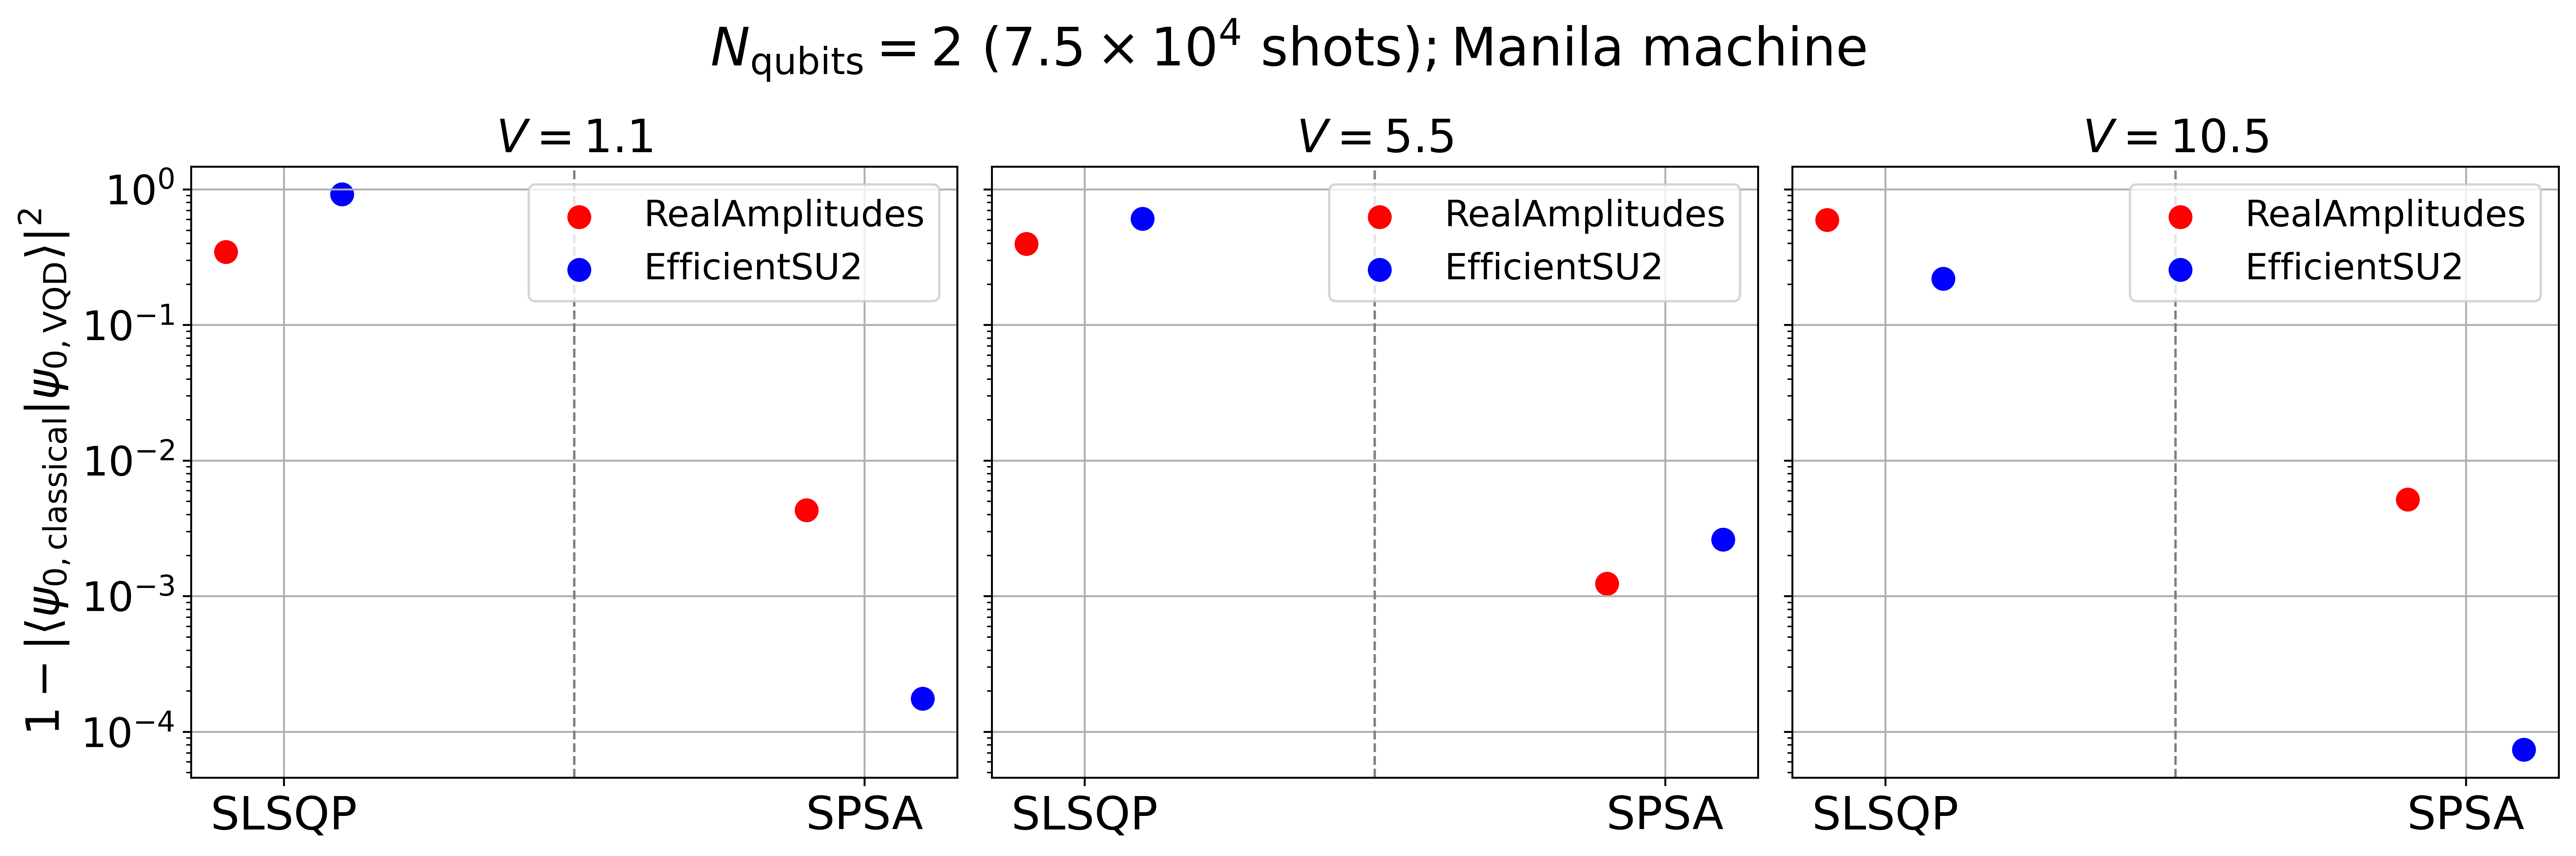

In [19]:
# Updated data
fidelities = {
    1.1: {
        "SLSQP": [np.array([[0.8092027]]), np.array([[0.2854632]])],
        "SPSA": [np.array([[0.99784245]]), np.array([[0.99991215]])]
    },
    5.5: {
        "SLSQP": [np.array([[0.77740503]]), np.array([[0.53343342]]), np.array([[0.62607428]])],
        "SPSA": [np.array([[0.99938028]]), np.array([[0.99869465]])]
    },
    10.5: {
        "SLSQP": [np.array([[0.63633804]]), np.array([[0.88370108]])],
        "SPSA": [np.array([[0.99741686]]), np.array([[0.99996318]])]
    }
}

# Replace fidelity of 1 with 0.999999
for V in fidelities.values():
    for optimizer, fidelity_lists in V.items():
        for i, fidelity in enumerate(fidelity_lists):
            V[optimizer][i] = np.where(fidelity == 1, 0.999999, fidelity)

# Infidelity calculation
def calculate_infidelity(fidelity):
    return 1 - fidelity**2

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, dpi = 600)
colors = ['red', 'blue']
markers = ['o', 'o']
ansatz_labels = ['RealAmplitudes', 'EfficientSU2']

for i, (V, data) in enumerate(fidelities.items()):
    ax = axs[i]
    infidelities = {
        "SLSQP": [calculate_infidelity(data["SLSQP"][0]), calculate_infidelity(data["SLSQP"][1])],
        "SPSA": [calculate_infidelity(data["SPSA"][0]), calculate_infidelity(data["SPSA"][1])]
    }
    x_positions = np.arange(len(infidelities))
    
    # Plot data for each optimizer
    for j, optimizer in enumerate(["SLSQP", "SPSA"]):
        for k, infidelity in enumerate(infidelities[optimizer]):
            ax.scatter(
                x_positions[j] + k * 0.2 - 0.1, 
                infidelity, 
                color=colors[k], 
                marker=markers[k], 
                label=ansatz_labels[k] if j == 0 else None,
                s=80
            )
    
    # Formatting
    ax.set_yscale('log')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(["SLSQP", "SPSA"], fontsize=19)
    ax.axvline(0.5, color='gray', linestyle='--', linewidth=1)
    ax.set_title(rf"$V = {V}$", fontsize=19)  
    ax.set_ylabel(r"$1 - |\langle\psi_{0, \mathrm{classical}}|\psi_{0, \mathrm{VQD}}\rangle|^2$" if i == 0 else "", fontsize=19)
    ax.tick_params(axis='y', labelsize=17)
    ax.grid(True)
    
    # Add legend inside the subplot
    ax.legend(fontsize=15, loc='best', frameon=True)

# Add a common title
fig.suptitle(r"$N_{\mathrm{qubits}} = 2 ~(7.5 \times 10^4 ~\mathrm{shots}); \mathrm{Manila ~machine}$", fontsize = 22)

# Adjust layout
fig.tight_layout(rect=[0, 0, 1, 1])
plt.show()

### Comparing the infidelity values and expectation values in the ground state

In [5]:
# Data preparation
fidelities = {
    1.1: {
        "SLSQP": [np.array([[0.8092027]]), np.array([[0.1602144]]), np.array([[0.2854632]])],
        "SPSA": [np.array([[0.99784245]]), np.array([[0.93507019]]), np.array([[0.99991215]])]
    },
    5.5: {
        "SLSQP": [np.array([[0.77740503]]), np.array([[0.53343342]]), np.array([[0.62607428]])],
        "SPSA": [np.array([[0.99938028]]), np.array([[0.99936535]]), np.array([[0.99869465]])]
    },
    10.5: {
        "SLSQP": [np.array([[0.63633804]]), np.array([[0.96905316]]), np.array([[0.88370108]])],
        "SPSA": [np.array([[0.99741686]]), np.array([[0.99984659]]), np.array([[0.99996318]])]
    }
}

expectations = {
    1.1: {
        "SLSQP": [np.array([[1.12519801]]), np.array([[1.45192285]]), np.array([[0.19795378]])],
        "SPSA": [np.array([[0.11559426]]), np.array([[0.52798738]]), np.array([[0.0032353]])]
    },
    5.5: {
        "SLSQP": [np.array([[1.67525264]]), np.array([[1.29945074]]), np.array([[0.56826396]])],
        "SPSA": [np.array([[0.05056891]]), np.array([[0.05047868]]), np.array([[0.06092739]])]
    },
    10.5: {
        "SLSQP": [np.array([[2.43098067]]), np.array([[0.2763866]]), np.array([[0.99649978]])],
        "SPSA": [np.array([[0.06653793]]), np.array([[0.00443206]]), np.array([[0.00642517]])]
    }
}

# Replace fidelity of 1 with 0.999999
for V in fidelities.values():
    for optimizer, fidelity_lists in V.items():
        for i, fidelity in enumerate(fidelity_lists):
            V[optimizer][i] = np.where(fidelity == 1, 0.999999, fidelity)

# Infidelity calculation
def calculate_infidelity(fidelity):
    return 1 - fidelity**2

# Plotting
fig, axs = plt.subplots(2, 3, figsize=(18, 10), dpi = 600)
colors = ['blue', 'red', 'purple']
markers = ['o', 's', '^']
ansatz_labels = ['RealAmplitudes', 'TwoLocal', 'EfficientSU2']

# First row: Infidelity plots
for i, (V, data) in enumerate(fidelities.items()):
    ax = axs[0, i]
    infidelities = {
        "SLSQP": [calculate_infidelity(data["SLSQP"][0]), calculate_infidelity(data["SLSQP"][1]), calculate_infidelity(data["SLSQP"][2])],
        "SPSA": [calculate_infidelity(data["SPSA"][0]), calculate_infidelity(data["SPSA"][1]), calculate_infidelity(data["SPSA"][2])]
    }
    x_positions = np.arange(len(infidelities))
    
    for j, optimizer in enumerate(["SLSQP", "SPSA"]):
        for k, infidelity in enumerate(infidelities[optimizer]):
            ax.scatter(
                x_positions[j] + k * 0.2 - 0.1, 
                infidelity, 
                color=colors[k], 
                marker=markers[k], 
                label=ansatz_labels[k] if j == 0 else None,
                s=80
            )
    
    ax.set_yscale('log')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(["SLSQP", "SPSA"], fontsize=17)
    ax.axvline(0.5, color='gray', linestyle='--', linewidth=1)
    ax.set_title(rf"$V = {V}$", fontsize=20)
    ax.tick_params(axis='y', labelsize=17)
    ax.grid(True)
    if i == 0:
        ax.set_ylabel(r"$1 - |\langle\psi_{0, \mathrm{classical}}|\psi_{0, \mathrm{VQD}}\rangle|^2$", fontsize=19)
    ax.legend(fontsize=16, loc='lower left', frameon=True)

# Second row: Expectation value plots
for i, (V, data) in enumerate(expectations.items()):
    ax = axs[1, i]
    x_positions = np.arange(len(data))
    
    for j, optimizer in enumerate(["SLSQP", "SPSA"]):
        for k, expectation in enumerate(data[optimizer]):
            ax.scatter(
                x_positions[j] + k * 0.2 - 0.1, 
                expectation, 
                color=colors[k], 
                marker=markers[k], 
                label=ansatz_labels[k] if j == 0 else None,
                s=80
            )

    ax.set_yscale('log')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(["SLSQP", "SPSA"], fontsize=17)
    ax.axvline(0.5, color='gray', linestyle='--', linewidth=1)
    ax.tick_params(axis='y', labelsize=17)
    ax.grid(True)
    if i == 0:
        ax.set_ylabel(r"$\langle Q \rangle$", fontsize=19)
    ax.legend(fontsize=16, loc='lower left', frameon=True)

# Add a common title
fig.suptitle(r"$N_{\mathrm{qubits}} = 2 ~(7.5 \times 10^4 ~\mathrm{shots}); \mathrm{Manila ~machine}$", fontsize=22, y = 0.94)

# Adjust layout and save the plot
fig.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig('Hardware noise analysis_Schlogl.pdf', bbox_inches = 'tight', dpi = 600)